Preparing

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import h5py
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
from numpy import format_float_scientific as ffs
import sys
sys.path.append("..")
import time as Time

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=10)
torch.manual_seed(1234)#1234
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


Main program

In [2]:
place = "./Result/"
name = "PINN_RSFparam_est_SSE"
case_number = 1 
print(name)

### observation
data_key = "ideal" #"true"
obs_span_day = 5

### Learning Parameter 
max_iter = 40000

PINN_RSFparam_est_SSE


In [3]:
%load_ext autoreload
%autoreload 2
plt.rcParams["mathtext.fontset"] = "stix"
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

In [4]:
### Same with .py file

### import the GNSS obervation
fname = "./Synthetic_Data_Surface_HN19.jld2"
f = h5py.File(fname, "r")
vsurf_data0 = np.array(f[data_key]["obs"])
t_data0 = np.array(f["time"])
f.close()

### import Green Function
fname = "./Green_Functions_HN2019.jld2"
f = h5py.File(fname, "r")
K = np.array(f["Fault/KernFF"]).T
K_obs = np.array(f["Obs"][data_key]["KernFO"]).T
Nobs = np.array(f["Obs"][data_key]["number"])[0]
f.close()

### information of true model (HN2019)
# frictional parameter
a_ = 0.001; b_ = 0.0003; bp = 0.0015; dc_ = 0.04
sigma0 = 100e6

# recurrence interval of SSE
cycle_time = 231552000 # ~7.3 yr

# initial condition
inicon = np.loadtxt("InitialCondition.dat")
v1 = inicon[0]
state1 = inicon[1]

### Define Fault geometry
FullFaultLengthStrike = 120e3
FullFaultLengthDip = 100e3 
FullFaultDepth = 25e3
StrikeAngle = 0 ; DipAngle = 15
CellLengthStrike = 2e3
CellLengthDip = 2e3

FFLS = FullFaultLengthStrike - CellLengthStrike; FFLD = FullFaultLengthDip - CellLengthDip
left_strike = - FFLS / 2  ; right_strike = FFLS / 2
left_dip    = - FFLD / 2  ; right_dip = FFLD / 2
mesh_strike = np.arange(left_strike, right_strike +1, CellLengthStrike)
mesh_dip    = np.arange(left_dip,    right_dip +1,    CellLengthDip   )
N_strike = len(mesh_strike); N_dip = len(mesh_dip)
N_cell =  N_strike * N_dip
patch_radius = 35e3 #35 km

#Define model parameters
year2sec = 365.25 * 24 * 60 * 60
TINY = 1e-20
G = 20  * 1e9 #Pa shear modulus
mu = 0.25 #poisson ratio
rho = 2400 #kg/m^3
vs = np.sqrt(G / rho) #m/s
eta = G / (2 * vs)
vpl = 6.5e-2 / year2sec #m/s
statepl = dc_ / vpl #s
#conversion from numpy to Tensor
K_t = torch.from_numpy(K).double().to(device)
K_obst = torch.from_numpy(K_obs).double().to(device)

###  Setting Collocation Point

span = 3600 * 24 * 10
t = np.arange(0, cycle_time+1 , span)
x = np.arange(- FullFaultLengthStrike / 2, FullFaultLengthStrike / 2, CellLengthStrike) + CellLengthStrike / 2
y = np.arange(- FullFaultLengthDip / 2, FullFaultLengthDip / 2, CellLengthDip) + CellLengthDip / 2

Nt = len(t); Nxy = len(x) * len(y)
print("Nt = ", Nt, " Nxy = ", Nxy)
x = x.reshape(1, -1); y = y.reshape(1, -1); t = t.reshape(1, -1)

X, T, Y  = np.meshgrid(x, t, y)
txy_test = np.hstack((T.flatten()[:, None], X.flatten()[:, None], Y.flatten()[:, None]))

lx = - FullFaultLengthStrike / 2; rx = FullFaultLengthStrike / 2
ly = - FullFaultLengthDip / 2   ; ry = FullFaultLengthDip / 2
lb = np.array([0, lx, ly]); ub = np.array([cycle_time, rx, ry])

N_uIni = 3000; N_f = len(txy_test)

def trainingdata(N_uIni, N_f):
    #Initial Condition t = 0
    initial_txy = np.hstack((T[0, :, :].flatten()[:, None], X[0, :, :].flatten()[:, None], Y[0, :, :].flatten()[:, None]))
    initial_u = np.hstack((np.log(v1[:, None] / vpl), np.log(state1[:, None] / statepl)))
    txy_ini_train = initial_txy
    u_ini_train = initial_u

    txy_f_train = np.copy(txy_test)

    return txy_ini_train, u_ini_train, txy_f_train

txy_ini_train_np, u_ini_train_np, txy_f_train_np = trainingdata(N_uIni, N_f)

### Define the mesh for evaluating stress
tau_x = np.arange(- FullFaultLengthStrike / 2, FullFaultLengthStrike / 2, CellLengthStrike) + CellLengthStrike / 2
tau_y = np.arange(- FullFaultLengthDip / 2, FullFaultLengthDip / 2, CellLengthDip) + CellLengthDip / 2
tau_t = np.copy(t)
tau_x = tau_x.reshape(1, -1); tau_y = tau_y.reshape(1, -1); tau_t = tau_t.reshape(1, -1)

TauX, TauT, TauY  = np.meshgrid(tau_x, tau_t, tau_y)
txy_tau = np.hstack((TauT.flatten()[:, None], TauX.flatten()[:, None], TauY.flatten()[:, None]))
txy_tau = torch.from_numpy(txy_tau).double().to(device)

#conversion from numpy to Tensor
txy_ini_train = torch.from_numpy(txy_ini_train_np).double().to(device)
u_ini_train = torch.from_numpy(u_ini_train_np).double().to(device)
txy_f_train =  torch.from_numpy(txy_f_train_np).double().to(device)
txy_test_tensor = torch.from_numpy(txy_test).double().to(device)
f_hat = torch.zeros(txy_f_train.shape[0],1).to(device)

### Define observation data
data_titer = range(0, len(t_data0), obs_span_day)
Nt_obs = len(data_titer)
x_data = np.arange(- FullFaultLengthStrike / 2, FullFaultLengthStrike / 2, CellLengthStrike) + CellLengthStrike / 2
y_data = np.arange(- FullFaultLengthDip / 2, FullFaultLengthDip / 2, CellLengthDip) + CellLengthDip / 2
x_data = x_data.reshape(1, -1); y_data = y_data.reshape(1, -1)
t_data = t_data0[data_titer].reshape(1, -1)

X, T, Y  = np.meshgrid(x_data, t_data, y_data)
txy_data = np.hstack((T.flatten()[:, None], X.flatten()[:, None], Y.flatten()[:, None]))
txy_data = torch.from_numpy(txy_data).double().to(device)

vsurf_data = vsurf_data0[:, :, data_titer]
vsurf_data = torch.from_numpy(vsurf_data).double().to(device)

"""Define NN"""

class Sequentialmodel(nn.Module):

    def __init__(self,layers, fp_layers):
        super().__init__()

        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')

        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.fp_linears = nn.ModuleList([nn.Linear(fp_layers[i], fp_layers[i+1]) for i in range(len(fp_layers)-1)])

        self.iter = 0

        self.loss_hist = [] #lossのリスト
        self.lossini_hist = []
        self.lossf_hist = []
        self.lossd_hist = []

        for i in range(len(layers)-1):
            #Xavier Initialization
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            nn.init.xavier_normal_(self.fp_linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.fp_linears[i].bias.data)

    #foward computation
    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        u_b = torch.from_numpy(ub).double().to(device)
        l_b = torch.from_numpy(lb).double().to(device)
        #scaling
        x = (x - l_b)/(u_b - l_b)
        #convert to double
        a = x.double()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)

        return a

    def fp_forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        u_b2 = torch.from_numpy(ub[1:]).double().to(device)
        l_b2 = torch.from_numpy(lb[1:]).double().to(device)
        #scaling
        x = (x - l_b2)/(u_b2 - l_b2)
        #convert to double
        a = x.double()
        for i in range(len(fp_layers)-2):
            z = self.fp_linears[i](a)
            a = self.activation(z)

        a = self.fp_linears[-1](a)

        return a

    #loss function induced from initial condition
    def loss_IC(self, txy, uini):

        z = txy.clone()
        z.requires_grad = True
        u = self.forward(z)

        loss_u = self.loss_function(u[:, :], uini[:, :])

        return loss_u

    def stress_field(self, t):
        tau_x = np.arange(- FullFaultLengthStrike / 2, FullFaultLengthStrike / 2, CellLengthStrike) + CellLengthStrike / 2
        tau_y = np.arange(- FullFaultLengthDip / 2, FullFaultLengthDip / 2, CellLengthDip) + CellLengthDip / 2
        tau_t = np.array([t.detach().cpu().numpy()])
        tau_x = tau_x.reshape(1, -1); tau_y = tau_y.reshape(1, -1); tau_t = tau_t.reshape(1, -1)

        TauX, TauT, TauY  = np.meshgrid(tau_x, tau_t, tau_y)
        txy_tau = np.hstack((TauT.flatten()[:, None], TauX.flatten()[:, None], TauY.flatten()[:, None]))
        txy_tau = torch.from_numpy(txy_tau).double().to(device)
        z = txy_tau.clone()

        u = self.forward(z)
        u_0 = torch.reshape(u[:, 0], (Nxy, 1)) #v
        velocity = vpl * torch.exp(u_0)

        stress_field = torch.mm(K_t, (velocity - vpl))

        return stress_field

    def loading_stress(self, txy):
        loading_stress = torch.zeros(txy.shape[0], 1).double().to(device)

        for i in range(Nt):
            loading_stress[Nxy * i : Nxy * (i+1)] = self.stress_field(txy[Nxy * i, 0])

        return loading_stress
    
    #loss function induced from governing equation
    def loss_PDE(self, txy):

        z = txy.clone()
        z.requires_grad = True

        u = self.forward(z)
        u_0 = torch.reshape(u[:, 0],(txy.shape[0],1)) #v
        u_1 = torch.reshape(u[:, 1],(txy.shape[0],1)) #state

        P_t = autograd.grad(u_0,z,torch.ones([txy.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0][:, 0].reshape(-1, 1)
        Q_t = autograd.grad(u_1,z,torch.ones([txy.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0][:, 0].reshape(-1, 1)

        velocity = vpl * torch.exp(u_0)
        state    = statepl * torch.exp(u_1)

        z2 = txy[:, 1:].clone()
        fp = self.fp_forward(z2)
        a =   1e-3  * torch.reshape(fp[:, 0], (txy.shape[0], 1))
        a_b =   1e-3  * torch.reshape(fp[:, 1], (txy.shape[0], 1))
        dc =  1e-2 * torch.reshape(fp[:, 2], (txy.shape[0], 1))
        b = a - a_b

        loading_stress = self.loading_stress(txy)

        eps = 1.0e-30
        p = a / (velocity + eps) + eta / sigma0
        r = 1.0 - velocity * state / dc
        q = loading_stress / sigma0 - b * r / (state + eps)

        f_P = P_t - q / (p * velocity)
        f_Q = Q_t - r / state

        #Lr = f_P ** 2 + f_Q ** 2
        loss_f_P = self.loss_function(f_P, f_hat)
        loss_f_Q = self.loss_function(f_Q, f_hat)

        loss_f = loss_f_P + loss_f_Q #self.loss_function(f,f_hat)
        dv_dt = velocity * P_t; dstate_dt = state * Q_t
        loss_f = loss_f * ((dc_ / vpl) ** 2)

        return loss_f, dv_dt, dstate_dt

    def loss_data(self, txy, vsurf_data):
        u = self.forward(txy)
        u_0 = torch.reshape(u[:, 0], (Nt_obs, N_cell)) #v
        velocity = vpl * torch.exp(u_0)
        vsurf = torch.matmul(K_obst, velocity.T)

        loss_d = self.loss_function(vsurf, vsurf_data)
        loss_d = loss_d / (vpl ** 2)

        return loss_d

    #summation of loss functions
    def loss(self,txy_ini_train,u_ini_train, txy_f_train):

        loss_ini = self.loss_IC(txy_ini_train,u_ini_train)
        loss_f, dv_dt, dstate_dt = self.loss_PDE(txy_f_train)
        loss_d = self.loss_data(txy_data, vsurf_data)

        loss_val = loss_ini + weight*loss_f + weight2*loss_d

        return loss_val, loss_ini, loss_f, loss_d

    #lossを計算し、自動微分を行う
    def closure(self):

        optimizer.zero_grad()
        loss ,loss_ini, loss_f, loss_d = self.loss(txy_ini_train,u_ini_train,txy_f_train)
        self.loss_hist.append(loss.item())
        self.lossini_hist.append(loss_ini.item())
        self.lossf_hist.append(loss_f.item())
        self.lossd_hist.append(loss_d.item())

        loss.backward()

        self.iter += 1

        if self.iter <= 9:
            _ = PINN.test()
            print('step=',self.iter, 'loss=', loss.item(),loss_ini.item(), loss_f.item())

        if self.iter % 100 == 0:
            _ = PINN.test()
            #print('step=',self.iter, ', loss=', loss.item(),loss_ini.item(), loss_f.item())
            print('step=',self.iter, 'loss=', loss.item(),loss_ini.item(), loss_f.item())

        return loss

    def test(self):

        u_pred_tensor = self.forward(txy_test_tensor)
        u_pred = u_pred_tensor.cpu().detach().numpy()
        #u_pred = np.reshape(u_pred,(Nt,8),order='F')

        return u_pred

    def input(self, txy):

        z = txy.clone()
        u_pred_tensor = self.forward(z)
        u_pred = u_pred_tensor.cpu().detach().numpy()
        #u_pred = np.reshape(u_pred,(Nt,8),order='F')

        return u_pred

"""最適化"""

def optimize(NN, epsilon, max_eval, loss_list, name):
    PINN = NN

    loss_iter = loss_list["total"]
    loss_ini = loss_list["ini"]
    loss_f = loss_list["ode"]
    loss_wf = loss_list["wode"]
    loss_data = loss_list["data"]
    loss_wdata = loss_list["wdata"]


    for i in range(max_eval):
        optimizer.step(PINN.closure)

        loss_temp = PINN.loss_hist[-1]
        loss_iter.append(loss_temp)
        loss_ini.append(PINN.lossini_hist[-1]) #loss_ini
        loss_f.append(PINN.lossf_hist[-1]) #純水なloss_ode
        loss_wf.append(PINN.lossf_hist[-1] * weight) #相対的重み付きloss * weight
        loss_data.append(PINN.lossd_hist[-1])
        loss_wdata.append(PINN.lossd_hist[-1] * weight2)

        if(abs(loss_iter[-1] - loss_iter[-2]) < epsilon):
            break

        if ((i+1) % 500 == 0):
              name0 = place + name + "_Interim"
              save_PINN(PINN, name0, loss_list)
        if ((i+1) % 1000 == 0):
              case_place = f"Case{case_number}/"
              name0 = place + case_place + name + f"_{i+1}"
              save_PINN(PINN, name0, loss_list)
    del loss_iter[0]
    #loss_eval = PINN.loss_hist

def save_PINN(PINN, name, loss_list):
    model = PINN.to(device)
    torch.save(model.state_dict(), name + '.pth')

    f = h5py.File(name + '_loss.h5', 'w')
    f["loss"] = loss_list["total"]
    f["loss_ini"] = loss_list["ini"]
    f["loss_f"] = loss_list["ode"]
    f["loss_wf"] = loss_list["wode"]
    f["loss_data"] = loss_list["data"]

    f.close()

    print("NN is saved")

def load_PINN(PINN, name, loss_list):

    PINN.load_state_dict(torch.load(name + '.pth', map_location=torch.device('cpu')))
    f = h5py.File(name + '_loss.h5', 'r')

    loss_list["total"] = np.array(f["loss"])
    loss_list["ini"] = np.array(f["loss_ini"])
    loss_list["ode"] = np.array(f["loss_f"])
    loss_list["wode"] = np.array(f["loss_wf"])
    loss_list["data"] = np.array(f["loss_data"])

    f.close()

    print("NN is loaded")

Nt =  269  Nxy =  3000


Load PINN

In [5]:
'''Fix seed'''
seed = 1234
torch.manual_seed(seed); np.random.seed(seed)

'''Load PINN'''
weight = 1; weight2 = 1
layers = np.array([3,20,20,20,20,20,20,20,20,2]); fp_layers = np.array([2,20,20,20,20,20,20,20,20,3])
PINN = Sequentialmodel(layers, fp_layers).to(device)
loss_list ={"total":[], "ini":[], "ode":[], "wode":[], "data":[], "wdata":[]}
load_PINN(PINN, place + name, loss_list)

NN is loaded


/var/folders/x0/rbgq83tj75v5rh80qy104z900000gn/T/ipykernel_7719/1463132622.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PINN.load_state_dict(torch.load(name + '.pth

L    :  7.865e-03
Lode :  3.222e-06
Lini :  3.050e-06
Ldata :  7.859e-03
Iteration :  40000


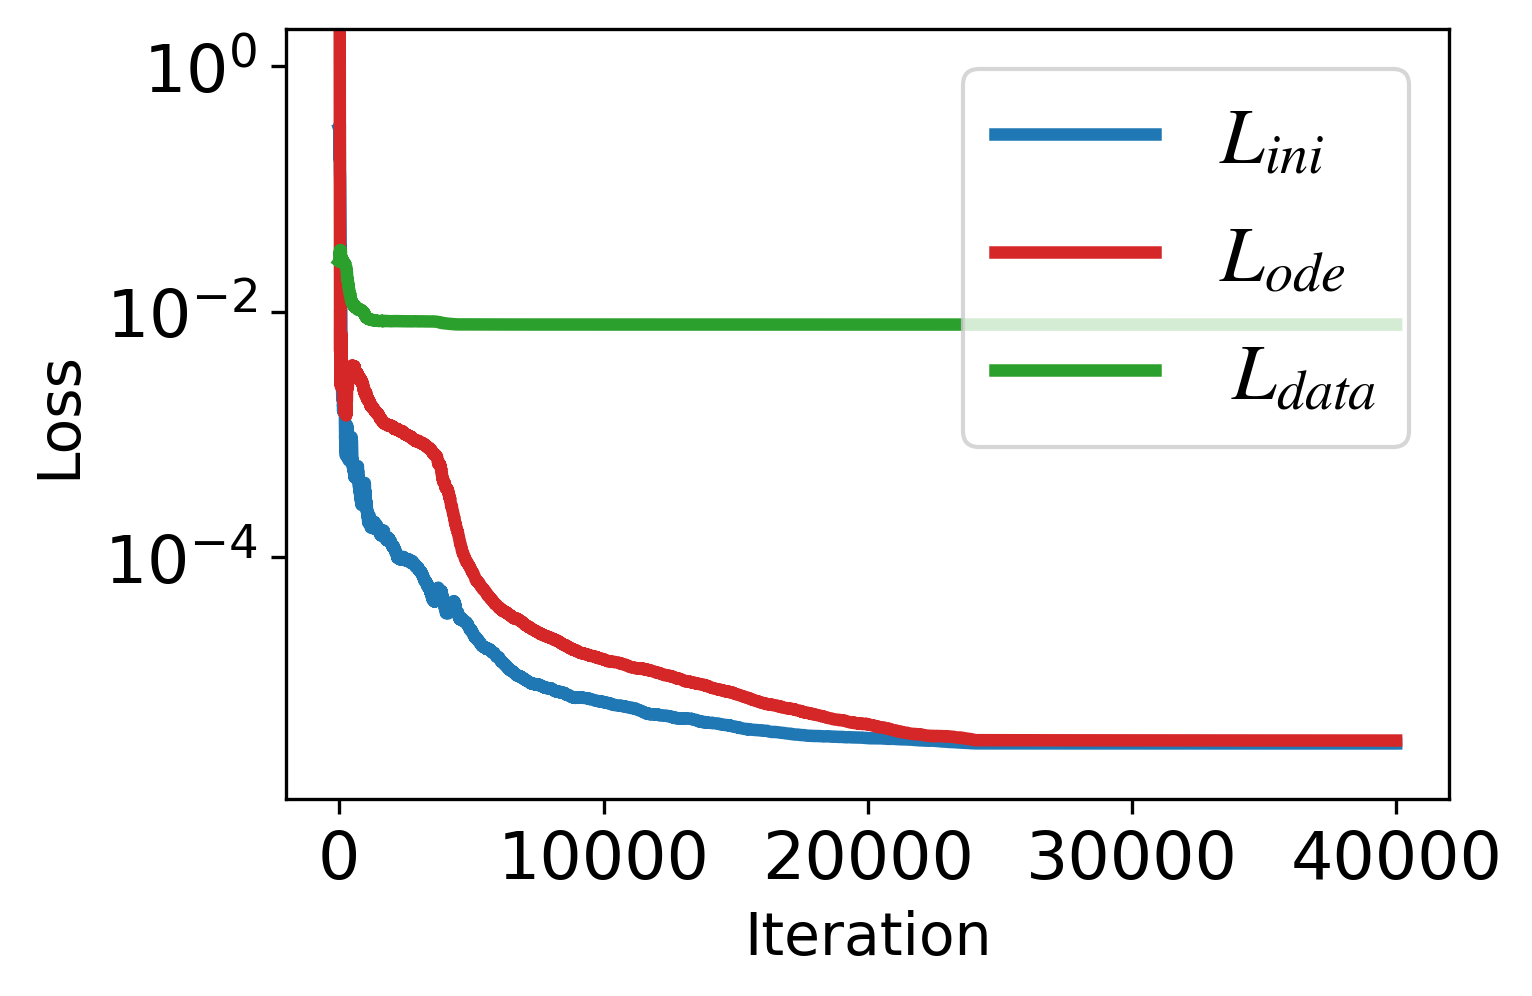

In [6]:
"""Learning Curve"""
max_iter = 1
loss = loss_list["total"]
loss_ini = loss_list["ini"]
loss_f = loss_list["ode"]
loss_data = loss_list["data"]

print("L    : ", ffs(loss[-1]  , 3, 2))
print("Lode : ", ffs(loss_f[-1], 3, 2))
print("Lini : ", ffs(loss_ini[-1], 3,2))
print("Ldata : ", ffs(loss_data[-1], 3,2))
print("Iteration : ", len(loss))

fig = plt.figure(figsize = (5, 10/3), dpi = 300)
fig.patch.set_facecolor('white')
#背景を透過しない

ax = fig.add_subplot(1, 1, 1)
ax.ticklabel_format(style="sci", scilimits=(0,0), axis="y",useMathText=True)
#sci:軸を科学表記, scilimits:桁を指数表記, useMathText指数を10^2表記

xiter = np.arange(0, len(loss_ini) * max_iter, max_iter)

ax.plot(xiter, loss_ini, label = r"$L_{ini}$", linewidth = 3, color = "tab:blue")
#ax.plot(xiter, loss_wf, label = r"$ w \: L_{ode}$")
ax.plot(xiter, loss_f, label = r"$ L_{ode}$", linewidth = 3, color = "tab:red")
ax.plot(xiter, loss_data, label = r"$ \: L_{data}$", linewidth = 3, color = "tab:green")
ax.set_yscale("log")

ax.set_xlabel("Iteration", fontsize = 14)
ax.set_ylabel("Loss", fontsize = 14)
ax.legend(fontsize = "large") #loc = 'upper right'

ax.set_ylim(None, 2)
plt.show()

In [7]:
dpi = 10

x_in = np.arange(- FullFaultLengthStrike / 2, FullFaultLengthStrike / 2, CellLengthStrike / dpi) + CellLengthStrike / 2 / dpi
y_in = np.arange(- FullFaultLengthDip / 2, FullFaultLengthDip / 2, CellLengthDip / dpi) + CellLengthDip / 2 / dpi
N_strike_in = len(x_in); N_dip_in = len(y_in)
x = x_in.reshape(1, -1); y = y_in.reshape(1, -1)

Y, X  = np.meshgrid(y, x)
xy_input = np.hstack(( X.flatten()[:, None], Y.flatten()[:, None]))

xy_input_tensor = torch.from_numpy(xy_input).double().to(device)

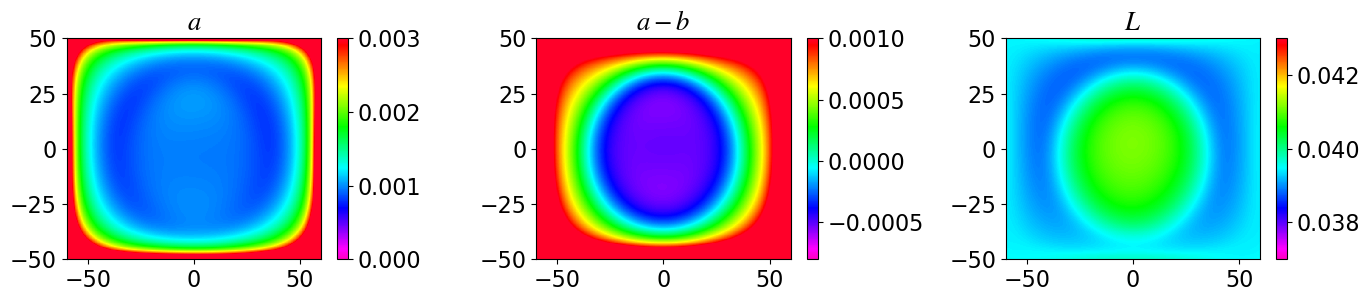

In [8]:
"""Estimated Frictional Parameter Distribution"""
fp = PINN.fp_forward(xy_input_tensor)
fp = fp.cpu().detach().numpy()
a =   1e-3  * fp[:, 0]; a_b =   1e-3  * fp[:, 1]; dc =  1e-2 * fp[:, 2]; b = a_b - a

fig, axs = plt.subplots(1, 3, figsize = (14, 3.3))

map1 = axs[0].pcolor(x_in / 1e3, y_in / 1e3, a.reshape(N_strike_in, N_dip_in).T, cmap = "gist_rainbow_r", vmin = 0, vmax = 3e-3)
map2 = axs[1].pcolor(x_in / 1e3, y_in / 1e3, a_b.reshape(N_strike_in, N_dip_in).T, cmap = "gist_rainbow_r", vmin = -8e-4, vmax = 10e-4)
map3 = axs[2].pcolor(x_in / 1e3, y_in / 1e3, dc.reshape(N_strike_in, N_dip_in).T, cmap = "gist_rainbow_r", vmin = 0.037, vmax = 0.043)

fig.colorbar(map1, ax = axs[0])#, label = r"$a$")
fig.colorbar(map2, ax = axs[1])#, label = r"$a-b$")
fig.colorbar(map3, ax = axs[2])#,label = r"L")
axs[0].set_title(r"$a$")
axs[1].set_title(r"$a-b$")
axs[2].set_title(r"$L$")
plt.tight_layout()
plt.show()

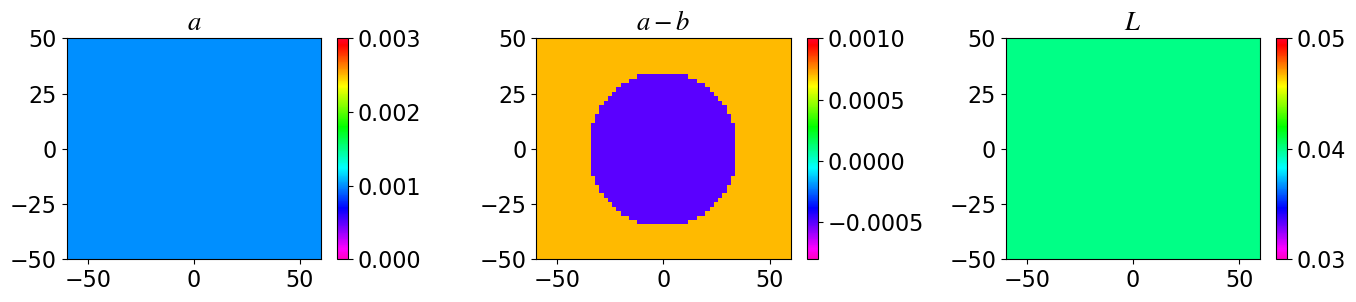

In [9]:
"""True Frictional Parameter Distribution"""
Y, X  = np.meshgrid(mesh_dip, mesh_strike)
xy_mesh = np.hstack(( X.flatten()[:, None], Y.flatten()[:, None]))
R = np.sqrt(xy_mesh[:, 0] ** 2 + xy_mesh[:, 1] ** 2)
a_true = a_ * np.ones(3000)
a_b_true = np.where(R < patch_radius, a_ - bp, a_ - b_)
dc_true = dc_ * np.ones(3000)

fig, axs = plt.subplots(1, 3, figsize = (14, 3.3))

map1 = axs[0].pcolor(mesh_strike / 1e3, mesh_dip / 1e3, a_true.reshape(N_strike, N_dip).T, cmap = "gist_rainbow_r", vmin = 0, vmax = 3e-3)
map2 = axs[1].pcolor(mesh_strike / 1e3, mesh_dip / 1e3, a_b_true.reshape(N_strike, N_dip).T, cmap = "gist_rainbow_r", vmin = -8e-4, vmax = 10e-4)
map3 = axs[2].pcolor(mesh_strike / 1e3, mesh_dip / 1e3, dc_true.reshape(N_strike, N_dip).T, cmap = "gist_rainbow_r", vmin = 0.03, vmax = 0.05)

fig.colorbar(map1, ax = axs[0])#, label = r"$a$")
fig.colorbar(map2, ax = axs[1])#, label = r"$a-b$")
fig.colorbar(map3, ax = axs[2])#,label = r"L")
axs[0].set_title(r"$a$")
axs[1].set_title(r"$a-b$")
axs[2].set_title(r"$L$")
plt.tight_layout()
plt.show()

In [10]:
### Input (t,x,y) to PINN
t = np.arange(0, cycle_time+1 , 24*3600)
x = np.arange(- FullFaultLengthStrike / 2, FullFaultLengthStrike / 2, CellLengthStrike) + CellLengthStrike / 2
y = np.arange(- FullFaultLengthDip / 2, FullFaultLengthDip / 2, CellLengthDip) + CellLengthDip / 2

Nt = len(t)
x = x.reshape(1, -1); y = y.reshape(1, -1); t = t.reshape(1, -1)
X, T, Y  = np.meshgrid(x, t, y)
txy_input = np.hstack((T.flatten()[:, None], X.flatten()[:, None], Y.flatten()[:, None]))
txy_input = torch.from_numpy(txy_input).double().to(device)
u_pred_tensor = PINN.forward(txy_input)
u_pred = u_pred_tensor.cpu().detach().numpy()

p = u_pred[:, 0]
q = u_pred[:, 1]
v = vpl * np.exp(p)
state = statepl * np.exp(q)
v = v.reshape(Nt, -1)
state = state.reshape(Nt, -1)

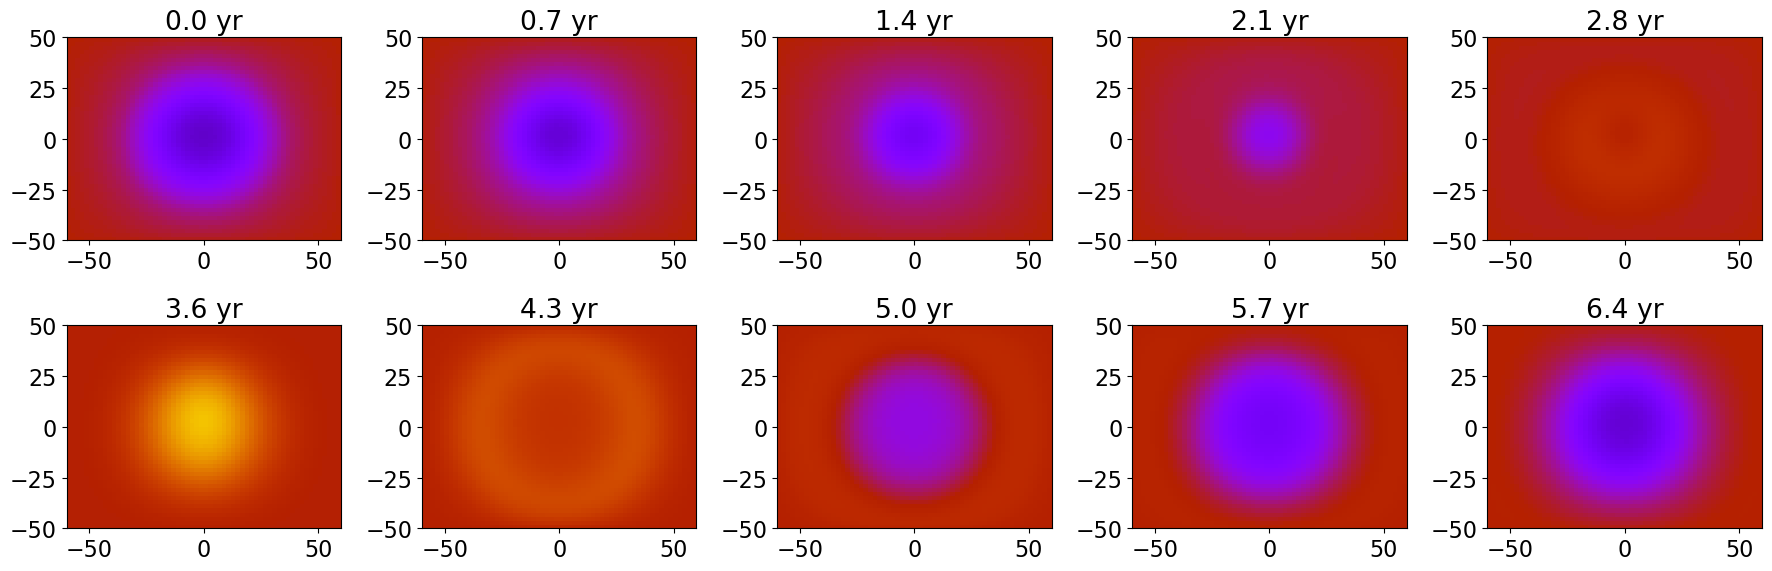

In [11]:
"""Fault Slip Distribution"""
fig, axs = plt.subplots(2, 5, figsize = (18, 6))
for i in range(10): 
        axs[i//5, i%5].pcolor(mesh_strike / 1e3, mesh_dip / 1e3, np.log10(v[260 * i] / vpl).reshape(N_strike, N_dip).T, cmap = "gnuplot", vmin = -1, vmax = 1)
        axs[i//5, i%5].set_title(f"{t[0, 260 * i] / year2sec:.1f} yr")
#fig.colorbar(map1, ax = axs[0], label = r"$\log_{10}(V/V_{pl})$")
plt.tight_layout()
plt.show()

Crustal Deformation

In [12]:
fname = "Synthetic_Data_Surface_HN19.jld2"
f = h5py.File(fname, "r")
vsurf_true0 = np.array(f[data_key]["true"])
f.close()

In [13]:
vsurf = np.matmul(K_obs, v.T) 

In [14]:
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

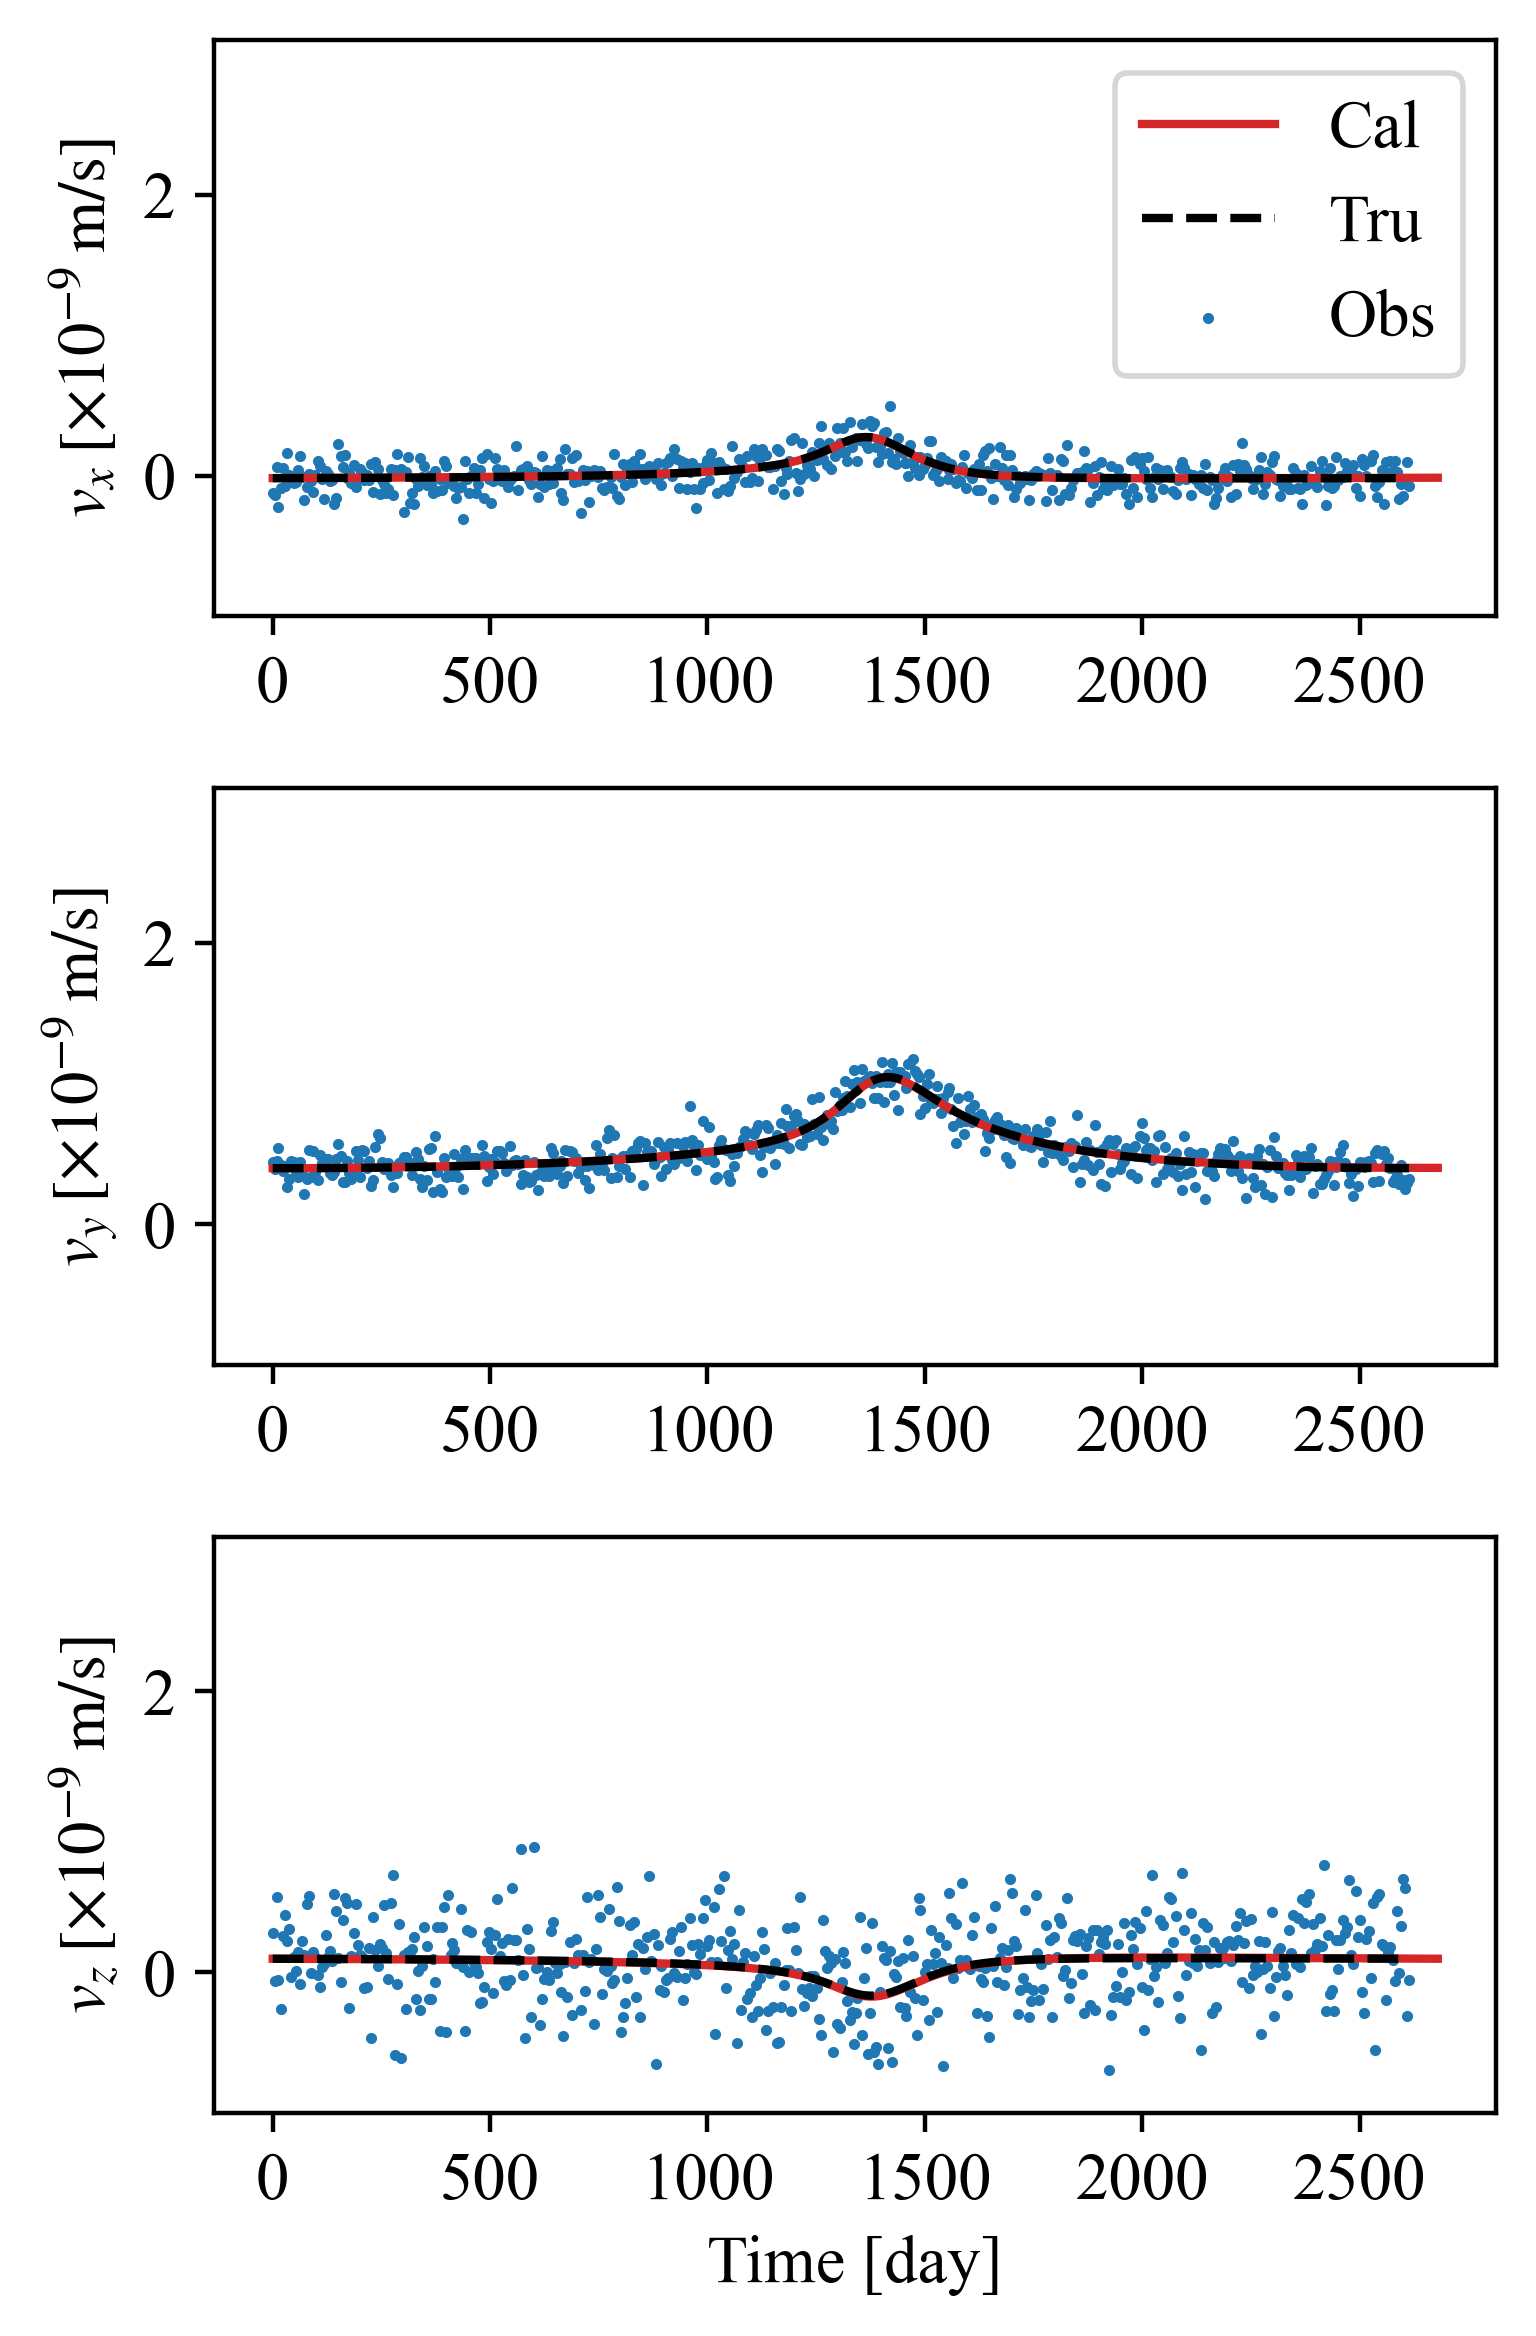

In [15]:
### Surface Displacement Velocity at Station 12
fig, axs = plt.subplots(3, 1, figsize = (4, 6), dpi = 400)
obs_iter = 12
day2sec = 24 * 60 * 60

for i in range(3):
    axs[i].plot(t[0] / day2sec, vsurf[i, obs_iter, :]* 1e9, label = "Cal", color = "tab:red")
    axs[i].plot(t_data0 / day2sec  , vsurf_true0[i, obs_iter, :] * 1e9, label = "Tru", color = "black", linestyle = "dashed")        
    axs[i].scatter(t_data / day2sec, vsurf_data[i, obs_iter,:] * 1e9, label = "Obs", color = "tab:blue", s = 1)
    axs[i].set_ylim(-1,3.1)
    
axs[0].legend(fontsize = "medium")
axs[0].set_ylabel(r"$v_{x} \: [\times 10^{-9} \: \rm{m/s}]$")
axs[1].set_ylabel(r"$v_{y} \: [\times 10^{-9} \: \rm{m/s}]$")
axs[2].set_ylabel(r"$v_{z} \: [\times 10^{-9} \: \rm{m/s}]$")
axs[2].set_xlabel("Time [day]")

plt.tight_layout()
plt.show()

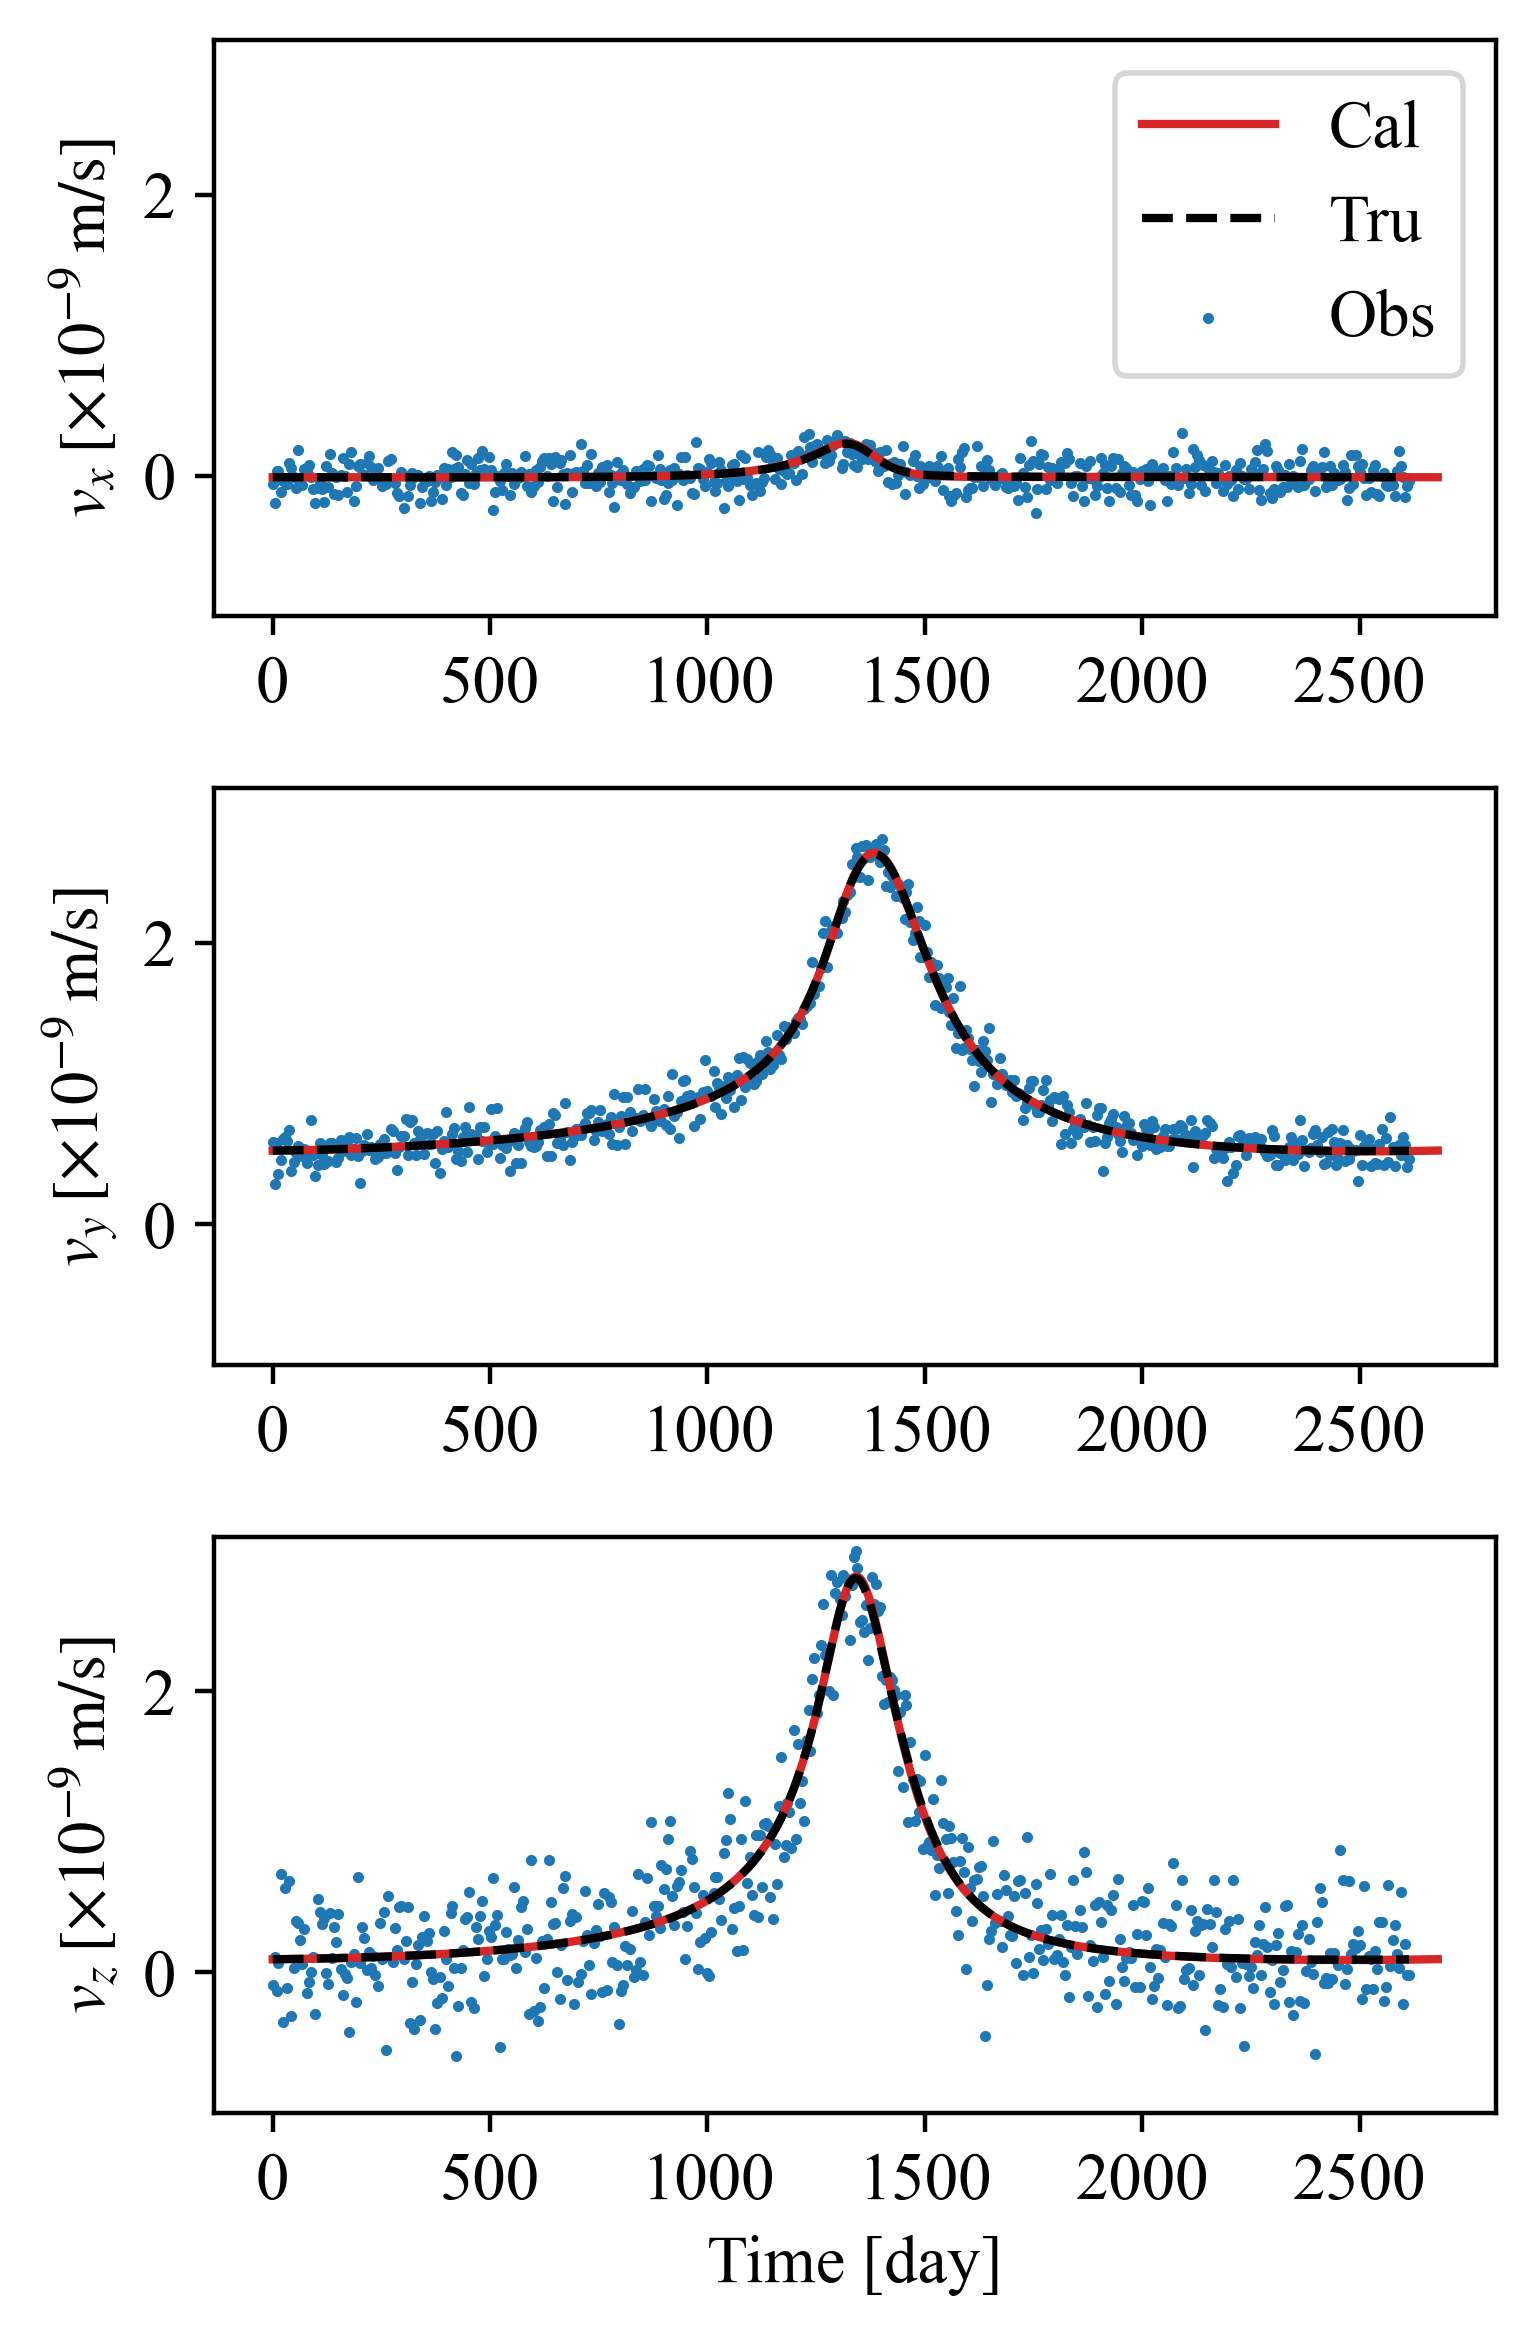

In [16]:
### Surface Displacement Velocity at Station 66
fig, axs = plt.subplots(3, 1, figsize = (4, 6), dpi = 400)
obs_iter = 66
day2sec = 24 * 60 * 60

for i in range(3):
    axs[i].plot(t[0] / day2sec, vsurf[i, obs_iter, :]* 1e9, label = "Cal", color = "tab:red")
    axs[i].plot(t_data0 / day2sec  , vsurf_true0[i, obs_iter, :] * 1e9, label = "Tru", color = "black", linestyle = "dashed")        
    axs[i].scatter(t_data / day2sec, vsurf_data[i, obs_iter,:] * 1e9, label = "Obs", color = "tab:blue", s = 1)
    axs[i].set_ylim(-1,3.1)
    
axs[0].legend(fontsize = "medium")
axs[0].set_ylabel(r"$v_{x} \: [\times 10^{-9} \: \rm{m/s}]$")
axs[1].set_ylabel(r"$v_{y} \: [\times 10^{-9} \: \rm{m/s}]$")
axs[2].set_ylabel(r"$v_{z} \: [\times 10^{-9} \: \rm{m/s}]$")
axs[2].set_xlabel("Time [day]")

plt.tight_layout()
plt.show()